# Temporal Reprojection

### Import and path setup

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch

import os

from kitti_utils import (
    compute_image_from_velodyne_matrices, load_lidar_points,
    get_camera_intrinsic_dict, get_relative_pose_between_consecutive_frames
)
from overlay_lidar_utils import (
     generate_lidar_point_coord_camera_image, plot_lidar_on_image, plot_point_hue_on_image
)
from compute_photometric_error_utils import (
    color_target_points_with_source, project_points_on_image, filter_to_plane, filter_to_fov,
    reproject_source_to_target, plot_sparse_img_and_surrounding_lidar,
    calc_photo_error_velo
)


# Set target and source for display
target = 11
source = 21

# Path names
calib_path = "data/kitti_example/2011_09_26"
scene_path = os.path.join(calib_path, "2011_09_26_drive_0048_sync")

RGB_MAX_DIST = np.sqrt(3) * 255

### Set target and source frames here:

In [2]:
# Set target and source for display
target = 11
source = 21

### Calculating transformation matrices and reading data from files

In [3]:
# Get transformation matrices
velo2cam = compute_image_from_velodyne_matrices(calib_path)["stereo_left"]
rel_pose = get_relative_pose_between_consecutive_frames(scene_path, target, source)

# Set velodyne points
target_velodyne = load_lidar_points(os.path.join(scene_path, f"velodyne_points/data/{target:010}.bin"))
orig_colors = np.copy(target_velodyne[:, 3])
target_velodyne[:, 3] = 1

# Read in image files
img_tgt = np.array(Image.open(os.path.join(scene_path, f"image_02/data/{target:010}.png")))
img_src = np.array(Image.open(os.path.join(scene_path, f"image_02/data/{source:010}.png")))

### Doing transformations and plotting

TypeError: unsupported operand type(s) for @: 'numpy.ndarray' and 'Tensor'

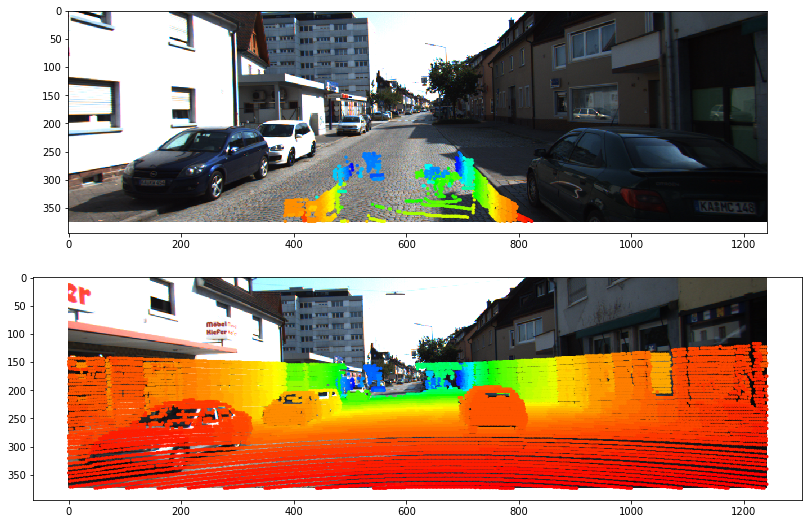

In [5]:
# Transform velodyne points into target and source camera planes
transform_to_src = target_velodyne @ rel_pose.T
src_coord = filter_to_fov(filter_to_plane(project_points_on_image(transform_to_src, velo2cam)), img_src.shape)
tgt_coord = filter_to_fov(filter_to_plane(project_points_on_image(target_velodyne, velo2cam)), img_tgt.shape)

# Plot lidar points on each image
fig = plt.figure(figsize=(32, 9))
plot_lidar_on_image(img_src, src_coord, fig, 1)
plot_lidar_on_image(img_tgt, tgt_coord, fig, 2)

# Project source lidar points (with color from source image) into target frame
color_points, point_tgt_frame = color_target_points_with_source(target_velodyne, img_src, velo2cam, rel_pose)
plot_sparse_img_and_surrounding_lidar(point_tgt_frame, color_points[:, :4], color_points[:, 4:] / 255)

# Calculate photometric error for each velodyne point and plot on target image (blue is more error)
fig = plt.figure(figsize=(32, 9))
errors = calc_photo_error_velo(img_tgt, color_points) / RGB_MAX_DIST
plot_point_hue_on_image(img_tgt, color_points, errors, fig, 1)

## With stereo reprojection functions

In [ ]:
lidar_point_coord_in_pixels_and_filt_idx = generate_lidar_point_coord_camera_image(target_velodyne, velo2cam, 1242,
                                                                                   375)
lidar_point_coord_camera_image_tgt = lidar_point_coord_in_pixels_and_filt_idx[0][
                                     lidar_point_coord_in_pixels_and_filt_idx[1], :]
# Get intrinsic matrix.
tgt_intrinsic = get_camera_intrinsic_dict(calib_path)["stereo_left"]

projection_coords = reproject_source_to_target(tgt_intrinsic, tgt_intrinsic,
                                               lidar_point_coord_camera_image_tgt, rel_pose)
lidar_point_coord_camera_image_tgt = projection_coords[0]
lidar_point_coord_camera_image_src = projection_coords[1]

# Get lidar points in front of velodyne sensor.
front_lidar_points_image_plane = lidar_point_coord_in_pixels_and_filt_idx[0]

# Load image file.
img_tgt_frac = img_tgt / 255

# Create array of colors for each pixel.
colors_tgt = np.zeros(lidar_point_coord_camera_image_tgt.shape)
for idx in range(len(colors_tgt)):
    x = lidar_point_coord_camera_image_tgt[idx][0]
    y = lidar_point_coord_camera_image_tgt[idx][1]
    colors_tgt[idx] = img_tgt_frac[y][x]

# Load source image file.
img_src_frac = img_src / 255
# Create array of colors for each pixel.
colors_src = np.zeros(lidar_point_coord_camera_image_tgt.shape)
for idx in range(len(colors_src)):
    x = lidar_point_coord_camera_image_src[idx][0]
    y = lidar_point_coord_camera_image_src[idx][1]
    if 0 <= x < 1242 and 0 <= y < 375:
        colors_src[idx] = img_src_frac[y][x]
    else:
        colors_src[idx] = np.array([[.75, .75, .75]])

# Sparsely plot target image and surrounding lidar.
plot_sparse_img_and_surrounding_lidar(front_lidar_points_image_plane,
                                           lidar_point_coord_camera_image_tgt[:, :2], colors_tgt)
# Sparsely plot source image projected into target image plane and surrounding lidar.
plot_sparse_img_and_surrounding_lidar(front_lidar_points_image_plane,
                                           lidar_point_coord_camera_image_tgt[:, :2], colors_src)